In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sin, cos, radians
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
sns.set()

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/PredictingTide/Data'

Mounted at /content/drive


# Get Data

In [4]:
df_data_1996 = pd.read_csv(f'{path}/BHPtrainingLongProcessed.zip', index_col = 'Date Time', parse_dates=True)
df_data_2016 = pd.read_csv(f'{path}/BHPtraining.csv', index_col = 'Date Time', parse_dates = True)
df_data_2020 = pd.read_csv(f'{path}/BHPtest.csv', index_col = 'Date Time', parse_dates = True)

In [5]:
'''df_raw = pd.read_csv(f'../Data/resampled_data.csv', index_col='DATE', parse_dates=True)'''

"df_raw = pd.read_csv(f'../Data/resampled_data.csv', index_col='DATE', parse_dates=True)"

In [6]:
def raw_dataset():
    df_raw = pd.concat([df_data_1996, df_data_2016, df_data_2020])
    return df_raw

# Process Data

In [7]:
def preprocess(dataframe):
    # Drop minute data
    df = dataframe[dataframe.index.minute == 0].copy()
    df = df.drop(['Water Level', 'Water Level Sigma'], axis=1)
    # Calculate across and along shore winds, offset of 30 degrees
    df['uWind'] = df['Wind Speed'].multiply(np.cos(np.radians(df['Wind Direction']-30)))
    df['vWind'] = df['Wind Speed'].multiply(np.sin(np.radians(df['Wind Direction']-30)))
    # Create Season feature
    df['season'] = np.where(df.index.month.isin([12, 1, 2]), 'winter',
                                np.where(df.index.month.isin([3, 4, 5]), 'spring',
                                         np.where(df.index.month.isin([6, 7, 8]), 'summer', 'fall')))
    # Create dummy variables for Season, to be used in regression model
    df = pd.get_dummies(df, columns=['season'], drop_first=True)
    #Remove significant outliers in Water Level
    df = df[np.abs(df['Air Temperature'] - df['Air Temperature'].mean()) <= (3 * df['Air Temperature'].std())]
    # Interpolate Missing Data: 3 hour limit for winds, 12 hour limit for Water Level, Surge, and Water Level Sigma
    df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']] = df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']].interpolate(method='linear', limit=12)
    # Drop remaining missing values

    return df

In [8]:
df_raw = raw_dataset()
df_clean = preprocess(df_raw)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121391 entries, 2001-10-28 00:00:00 to 2020-10-21 01:00:00
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Air Temperature  121391 non-null  float64
 1   Wind Speed       121391 non-null  float64
 2   Wind Direction   121003 non-null  float64
 3   Wind Gust        121391 non-null  float64
 4   uWind            121391 non-null  float64
 5   vWind            121391 non-null  float64
 6   season_spring    121391 non-null  bool   
 7   season_summer    121391 non-null  bool   
 8   season_winter    121391 non-null  bool   
dtypes: bool(3), float64(6)
memory usage: 6.8 MB


In [9]:
df_clean.head()

,Air Temperature,Wind Speed,Wind Direction,Wind Gust,uWind,vWind,season_spring,season_summer,season_winter
Date Time,,,,,,,,,
2001-10-28 00:00:00,55.8,0.0,87.0,0.0,0.0,0.0,False,False,False
2001-10-28 01:00:00,55.4,0.0,81.0,0.0,0.0,0.0,False,False,False
2001-10-28 02:00:00,54.5,0.0,98.0,0.0,0.0,0.0,False,False,False
2001-10-28 03:00:00,53.4,0.0,100.0,0.0,0.0,0.0,False,False,False
2001-10-28 04:00:00,52.3,0.0,108.0,0.0,0.0,0.0,False,False,False


# Explore Data

## Autocorrelation

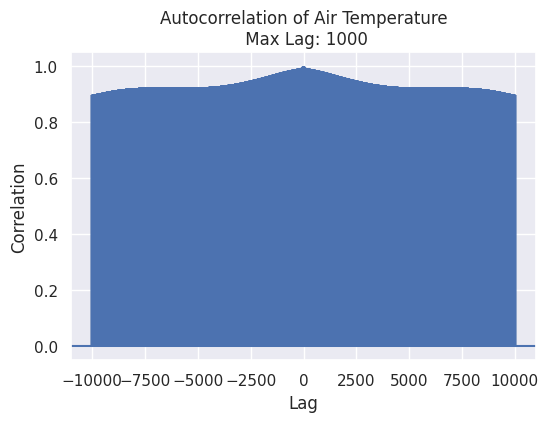

In [10]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['Air Temperature'], maxlags=10000)
plt.title('Autocorrelation of Air Temperature\n Max Lag: 1000')
plt.xlabel('Lag')
plt.ylabel('Correlation');


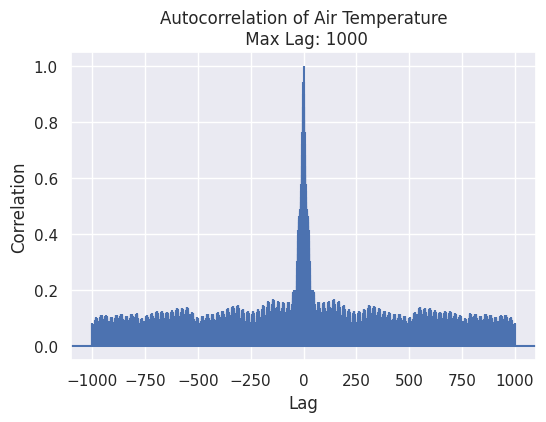

In [11]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['uWind'], maxlags=1000)
plt.title('Autocorrelation of Air Temperature\n Max Lag: 1000')
plt.xlabel('Lag')
plt.ylabel('Correlation');

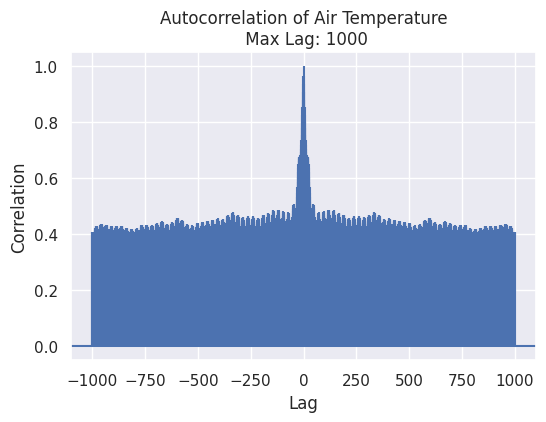

In [12]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['vWind'], maxlags=1000)
plt.title('Autocorrelation of Air Temperature\n Max Lag: 1000')
plt.xlabel('Lag')
plt.ylabel('Correlation');

## Correlation Analysis

In [13]:
df_clean.corr()

,Air Temperature,Wind Speed,Wind Direction,Wind Gust,uWind,vWind,season_spring,season_summer,season_winter
Air Temperature,1.000000,0.058916,-0.177583,0.025614,-0.371980,0.551400,-0.061292,0.536759,-0.679702
Wind Speed,0.058916,1.000000,-0.039394,0.983204,0.037535,0.264806,0.112459,0.010427,-0.099055
Wind Direction,-0.177583,-0.039394,1.000000,0.010355,-0.231769,-0.380247,-0.058105,-0.017696,0.061436
Wind Gust,0.025614,0.983204,0.010355,1.000000,0.068125,0.184457,0.113664,-0.009284,-0.091898
uWind,-0.371980,0.037535,-0.231769,0.068125,1.000000,-0.523770,-0.009749,-0.260496,0.180164
vWind,0.551400,0.264806,-0.380247,0.184457,-0.523770,1.000000,0.145019,0.248151,-0.307807
season_spring,-0.061292,0.112459,-0.058105,0.113664,-0.009749,0.145019,1.000000,-0.320780,-0.325458
season_summer,0.536759,0.010427,-0.017696,-0.009284,-0.260496,0.248151,-0.320780,1.000000,-0.326341
season_winter,-0.679702,-0.099055,0.061436,-0.091898,0.180164,-0.307807,-0.325458,-0.326341,1.000000


## Seasonal Analysis

## Distribution Plots

<Axes: xlabel='Date Time', ylabel='Air Temperature'>

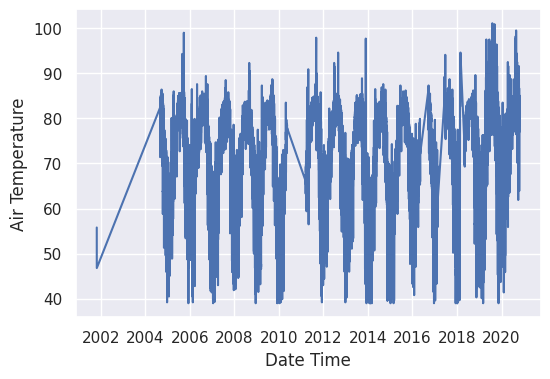

In [14]:
fig=plt.figure(figsize=(6,4))
sns.lineplot(data=df_clean, x=df_clean.index, y=df_clean['Air Temperature'])

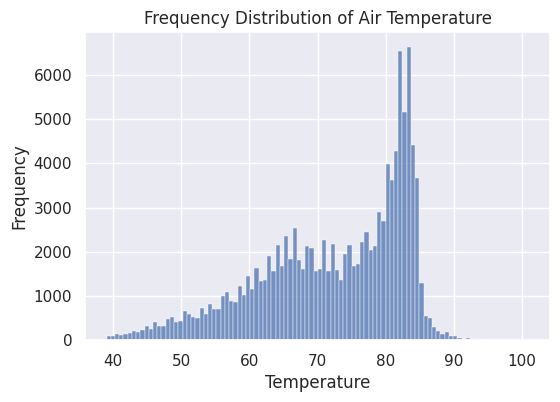

In [15]:
fig=plt.figure(figsize=(6,4))
sns.histplot(df_clean['Air Temperature'], bins=100);
plt.title("Frequency Distribution of Air Temperature")
plt.ylabel("Frequency")
plt.xlabel("Temperature");

## Summary Statistics

# Prepare Data

## Prepare Labels/Features

In [16]:
def data_sample(df, features, leadtime_hours=24):
  data = []
  labels = []

  for index, row in df.iterrows():

    if index.hour == 0 or index.hour == 12:
        # Start and End time for 24 hours prior to observation
        end_datetime = index - pd.Timedelta(hours = 24)
        start_datetime = end_datetime - pd.Timedelta(hours = leadtime_hours)

        # Slice the DataFrame into 24 hour windows
        window = df.loc[start_datetime:end_datetime]
        # If we do not have 24 hours of continuous data, throw out interval
        if window.shape != (leadtime_hours + 1, df.shape[1]):
            continue

        # Extract the ith observation for our label value
        label = None
        try:
            label = df.loc[index]['Air Temperature']
        except KeyError:
            continue

        # Transform each feature into a array containing 24 hours worth of values of that feature
        input_vector = []
        for feature in features:
            input_vector = input_vector + window[feature].tolist()

        data.append(input_vector)
        labels.append(label)

  return data, labels

## Evaluation Functions

In [17]:
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 5:
            temp = temp + 1
    return temp / len(predictions)

In [18]:
def evaluate(predictions, labels, predictions_best):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

    mse_best = mean_squared_error(predictions_best, labels)
    r2_best = r2_score(predictions_best, labels)
    cf_best = central_frequency(predictions_best, labels)

    print('-------------------')
    print('Difference from Current Best Model')
    print('-------------------')
    print('Central Frequency Difference: {:.6f}'.format(cf_best-cf))
    print('Mean Square Error Difference:{:.6f}'.format(mse_best-mse))
    print('R-squared Difference:{:.6f}'.format(r2_best-r2))
    print('')

In [19]:
def evaluate_final(predictions, labels):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

In [20]:
def model_plot(predictions, labels):
    plt.figure(figsize=(25,10))
    plt.plot(labels, label='Targets')
    plt.plot(predictions, label='Predictions')
    plt.title('Predictions vs Targets', size=22)
    plt.xlabel('Observation (24hr Lag)', size=22)
    plt.ylabel('Temperature', size=22)
    plt.legend()
    plt.show()

## Train/Validate/Test Split

In [21]:
def data_split(dataframe):
    train = dataframe[((dataframe.index.year >= 1996) & (dataframe.index.year <= 2018))]
    validate = dataframe[dataframe.index.year == 2019]
    test = dataframe[dataframe.index.year == 2020]

    return train, validate, test

In [22]:
df_train, df_validate, df_test = data_split(df_clean)

# Linear Regression

In [23]:
training_data, training_labels = data_sample(df_train, ['Air Temperature'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature'])
model = LinearRegression()
model.fit(training_data, training_labels)
models = {'LR/Temp': [model.predict(training_data), model.predict(validation_data), model.predict(testing_data)]}

In [24]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature',  'vWind',  'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(training_data)
evaluate_final(predictions, training_labels)
models['LR/All'] = [model.predict(training_data), model.predict(validation_data), model.predict(testing_data)]


Central Frequency: 0.8630970489808336
Mean Squared Error: 16.430204124854658
Root Mean Squared Error: 4.053418819324579
R-squared: 0.823338745727401


In [25]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

In [26]:
for key in models.keys():
    print(models[key][0])

[80.37858817 81.5506742  82.31961379 ... 69.45018296 52.67228719
 49.55146417]
[79.11655374 81.52961393 81.61795247 ... 65.49465483 53.96359993
 50.99608443]


In [27]:
def compare_rmse(models):
    training_rmse = [rmse(training_labels, models[key][0]) for key in models.keys()]
    validation_rmse = [rmse(validation_labels, models[key][1]) for key in models.keys()]
    testing_rmse = [rmse(testing_labels, models[key][2]) for key in models.keys()]

    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="Validation RMSE"),
        go.Bar(x = names, y = testing_rmse, name="Test RMSE", opacity=.3)])
    return fig

In [28]:
def compare_cf(models):
    training_rmse = [central_frequency(training_labels, models[key][0]) for key in models.keys()]
    validation_rmse = [central_frequency(validation_labels, models[key][1]) for key in models.keys()]
    testing_rmse = [central_frequency(testing_labels, models[key][2]) for key in models.keys()]

    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training CF"),
        go.Bar(x = names, y = validation_rmse, name="Validation CF"),
        go.Bar(x = names, y = testing_rmse, name="Test CF", opacity=.3)])
    return fig

In [42]:
fig = compare_rmse(models)
fig.update_yaxes(range=[2,5.1], title="RMSE")

In [30]:
fig = compare_cf(models)
fig.update_yaxes(range=[0,1], title="Central Frequency")

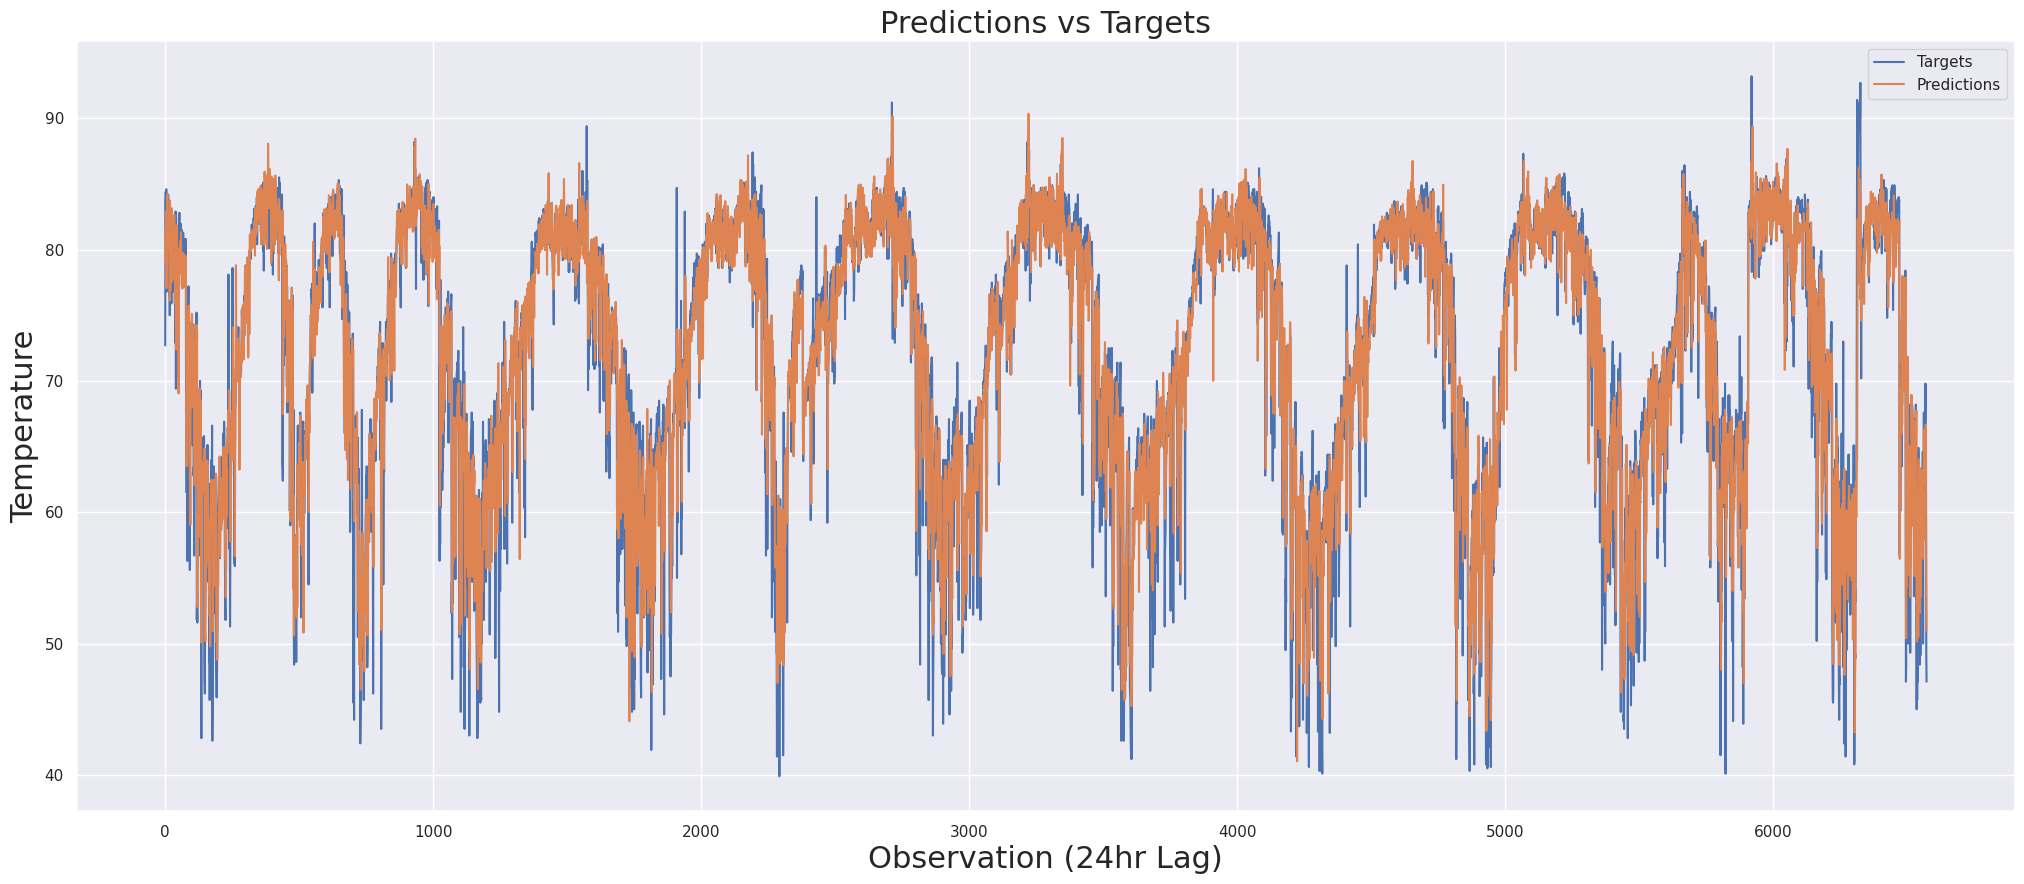

In [31]:
model_plot(predictions, training_labels)

In [32]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)


Central Frequency: 0.8309859154929577
Mean Squared Error: 24.369315640069072
Root Mean Squared Error: 4.936528703458441
R-squared: 0.8006635204861392


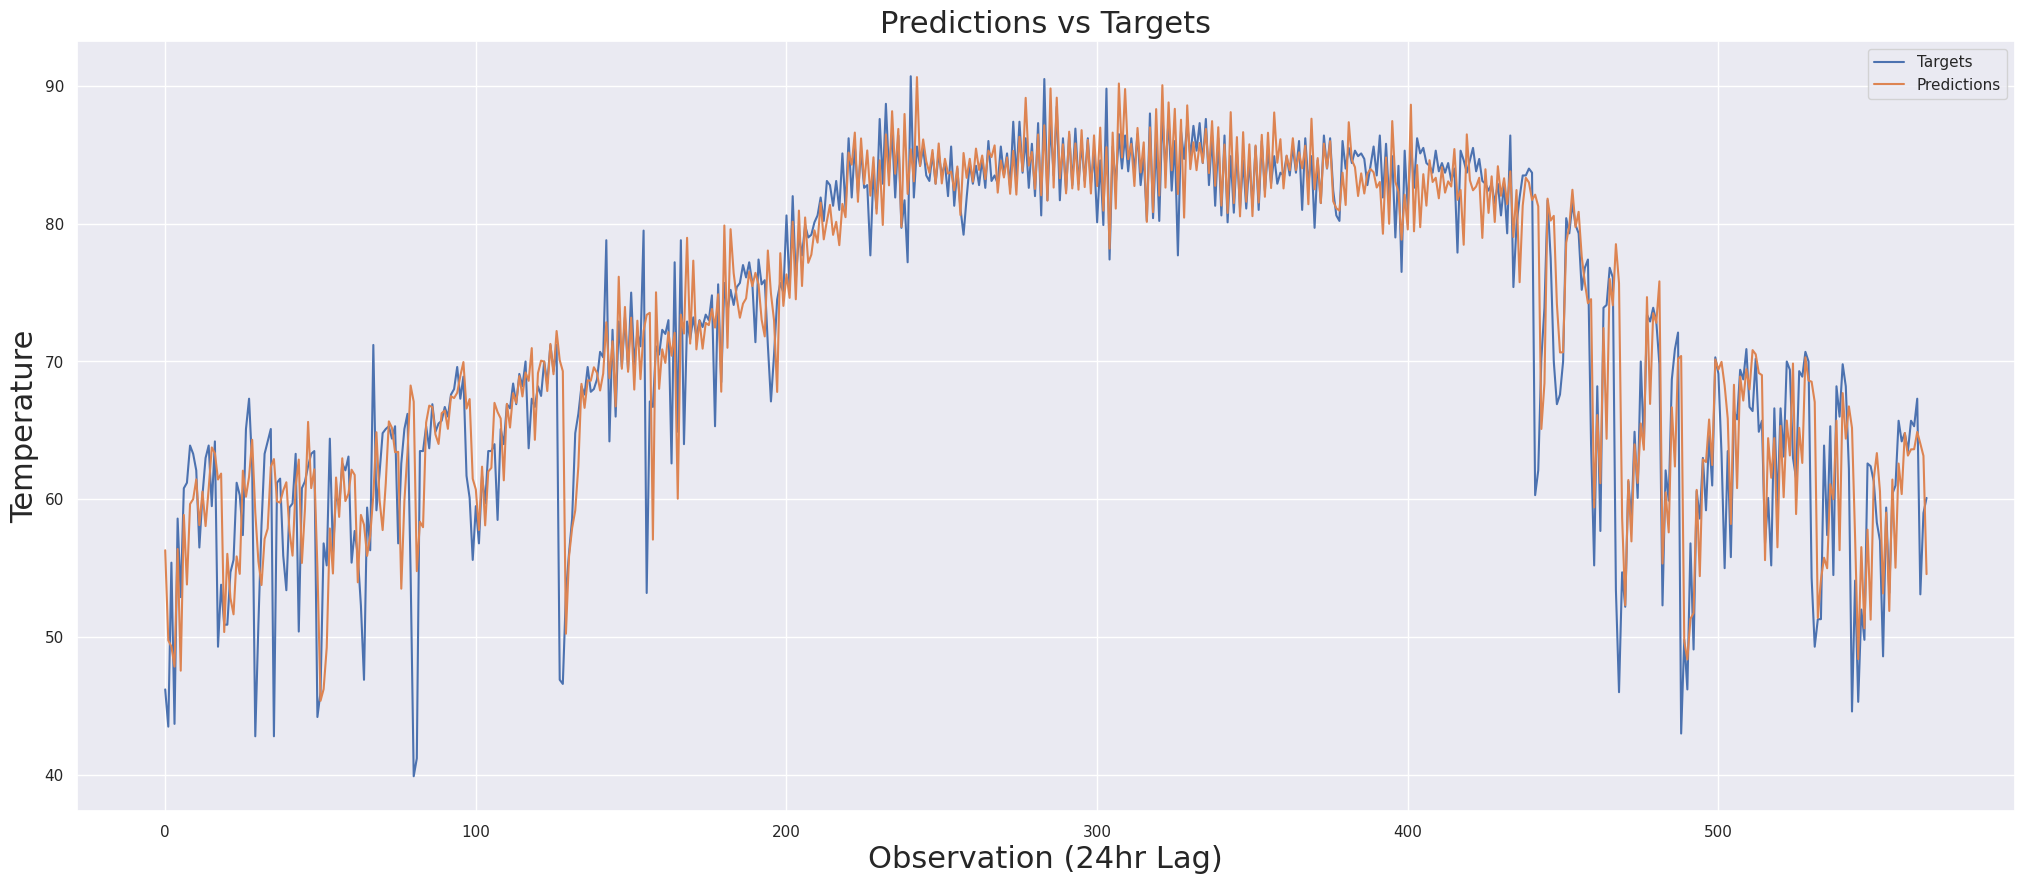

In [33]:
model_plot(predictions, validation_labels)

In [34]:
predictions = model.predict(testing_data)
evaluate_final(predictions, testing_labels)


Central Frequency: 0.875717017208413
Mean Squared Error: 12.474642502653786
Root Mean Squared Error: 3.531945993734019
R-squared: 0.8395454864896237


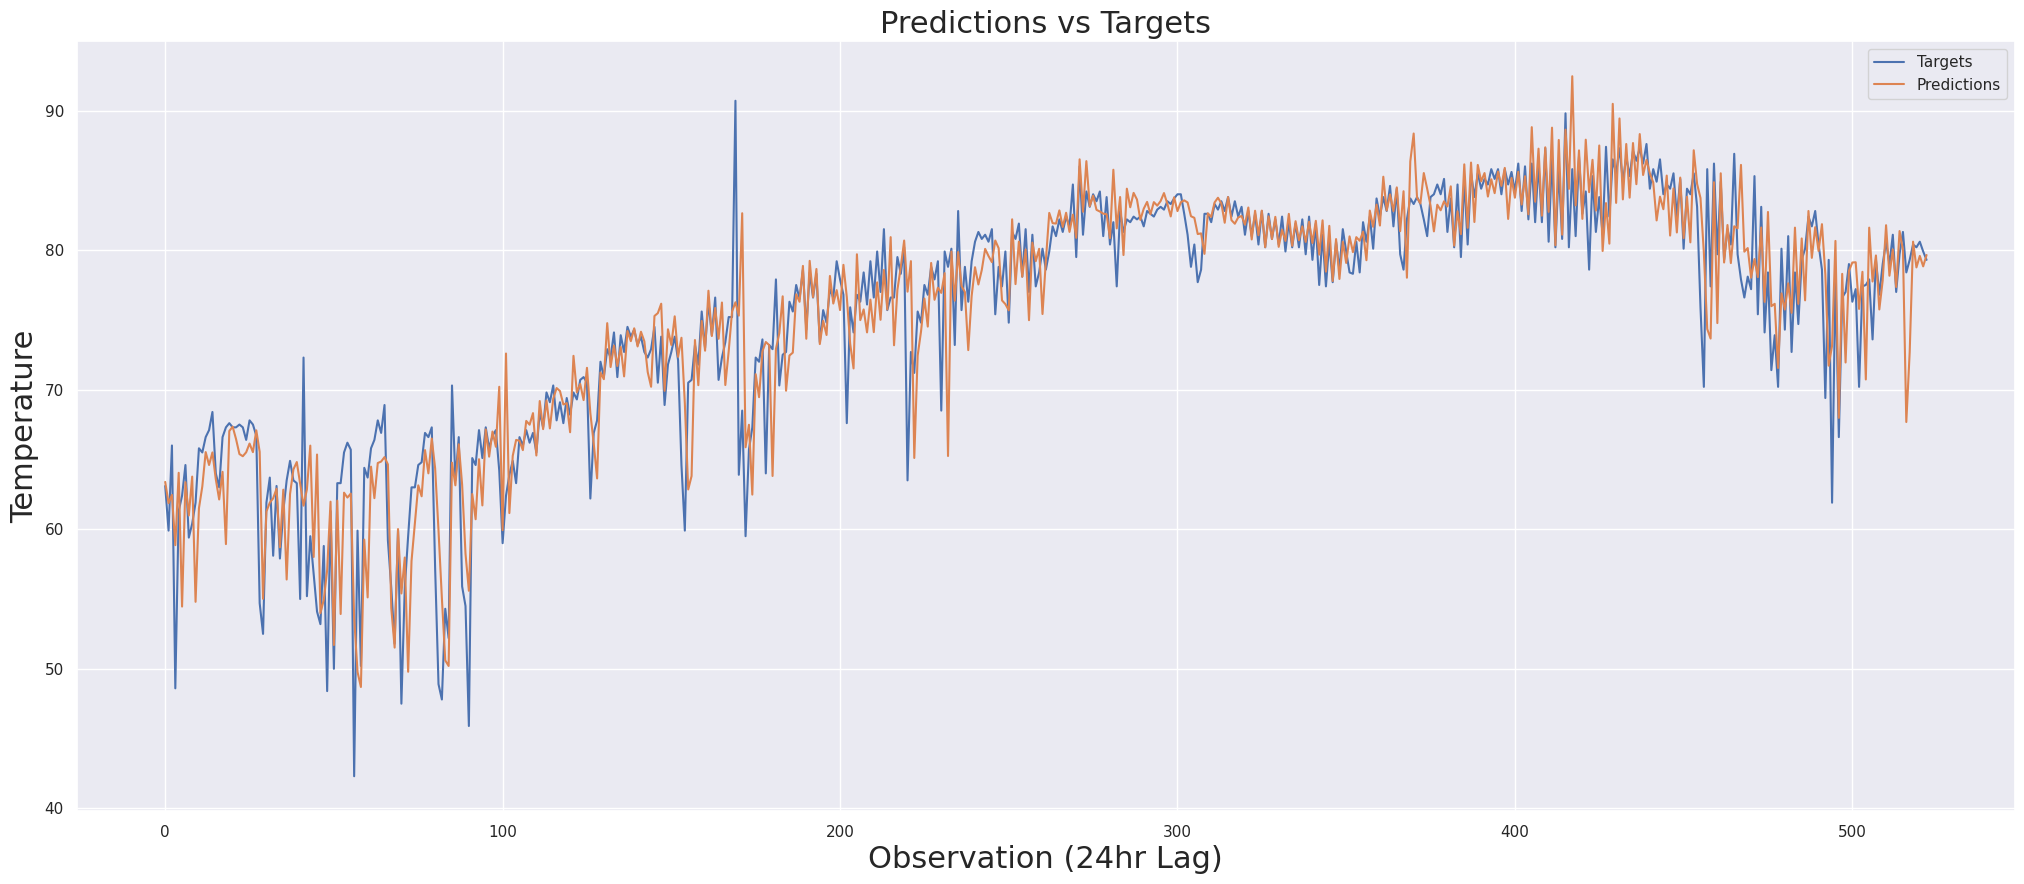

In [35]:
model_plot(predictions, testing_labels)

# Random Forest

In [36]:
rf = RandomForestRegressor(n_estimators=128)

In [37]:
rf.fit(training_data, training_labels)

RandomForestRegressor(n_estimators=128)

In [38]:
predictions = rf.predict(training_data)
evaluate_final(predictions, training_labels)


Central Frequency: 0.9838758746577426
Mean Squared Error: 2.343998965781839
Root Mean Squared Error: 1.53101239896411
R-squared: 0.9765508446199211


In [39]:
predictions = rf.predict(validation_data)
evaluate_final(predictions, validation_labels)


Central Frequency: 0.8309859154929577
Mean Squared Error: 23.566589513429456
Root Mean Squared Error: 4.854543182775229
R-squared: 0.8012248179728007


In [40]:
predictions = rf.predict(testing_data)
evaluate_final(predictions, testing_labels)


Central Frequency: 0.8604206500956023
Mean Squared Error: 13.790768738376487
Root Mean Squared Error: 3.71359243029933
R-squared: 0.8219797293889279


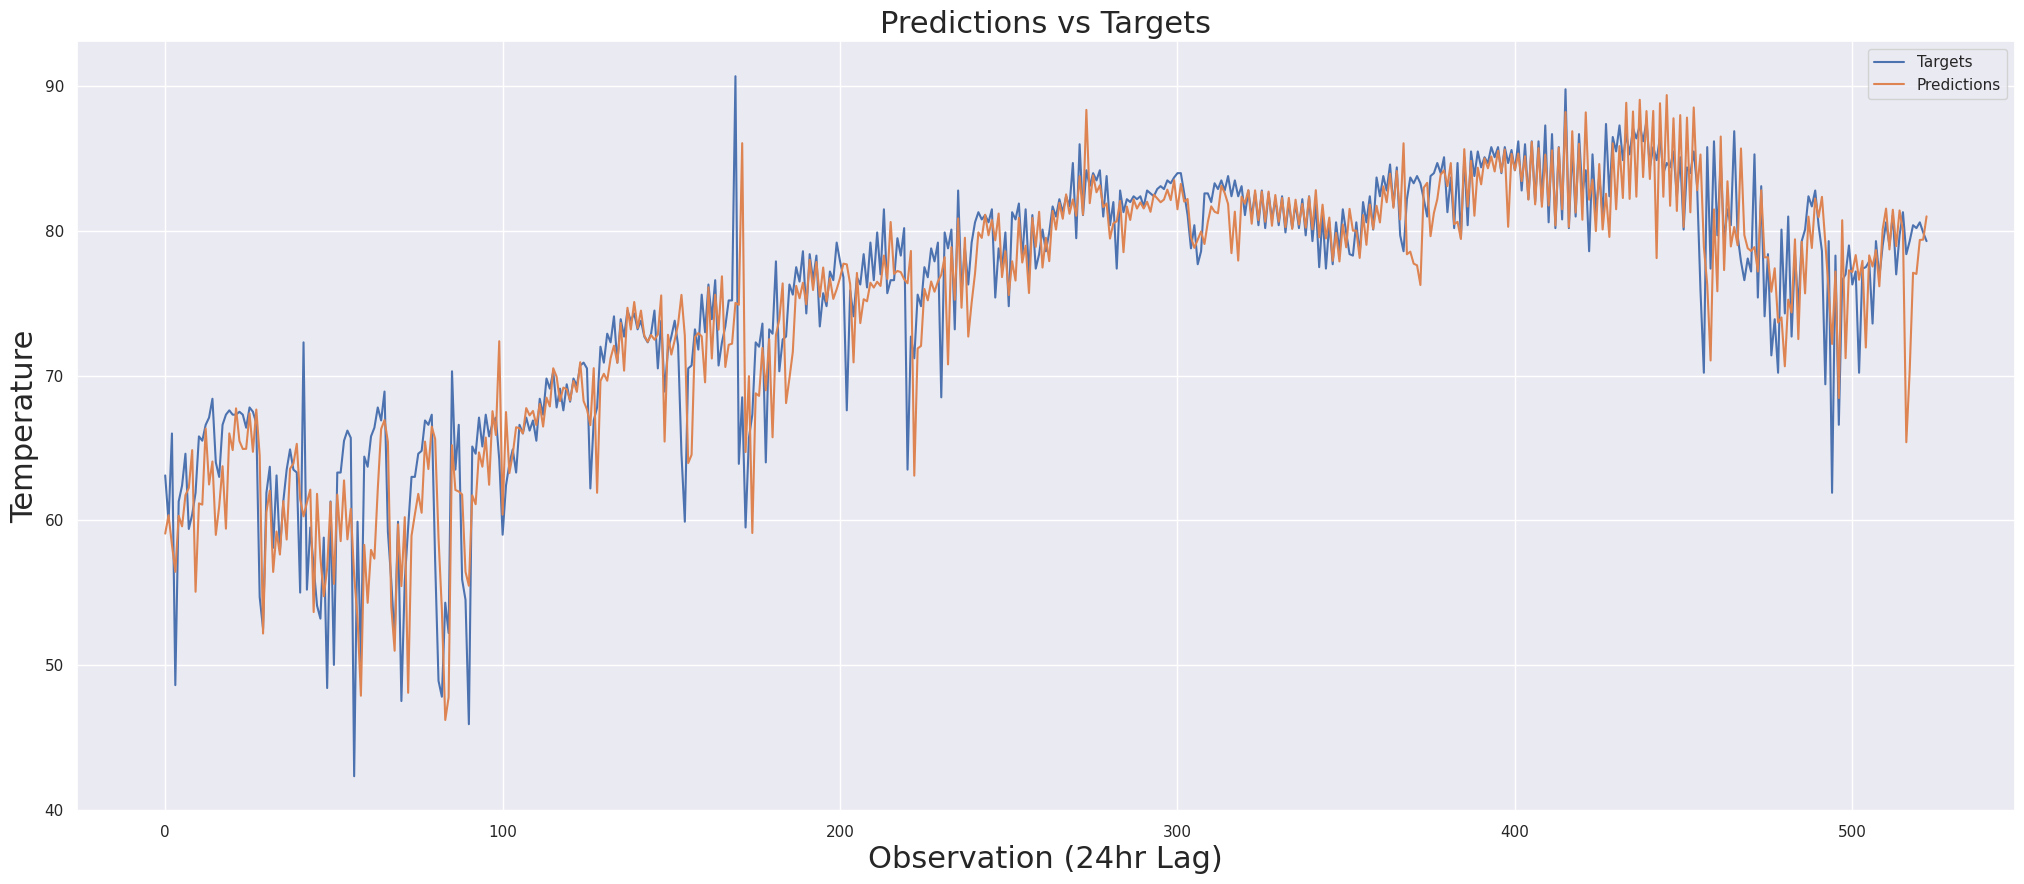

In [41]:
model_plot(predictions, testing_labels)

# Compare Model Performance

# Conclusion